In [4]:
%load_ext autoreload
%autoreload 2

import cv2
import numpy as np
import numpy.linalg as npl
from matplotlib import pyplot as plt
from matplotlib import cbook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Experimenting with recreating the image using albedo and shading

In [51]:
# Just to avoid more typing than necessary
def imshow(input):
    plt.axis('off')
    plt.imshow(input)

In [52]:
img = plt.imread('./church/input.png')
normals = plt.imread('./church/normals.png')
albedo = plt.imread('./church/ours_alb.png')
shading = plt.imread('./church/ours_shd.png')
shading = np.dstack((shading, shading, shading))
gamma = 0.4545
# ^ shading now has 3 channels despite being grayscale
# otherwise numpy will complain shapes of albedo and shading do not match

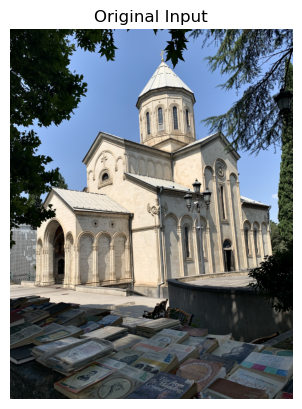

In [53]:
plt.axis('off')
plt.title("Original Input")
plt.imshow(img)

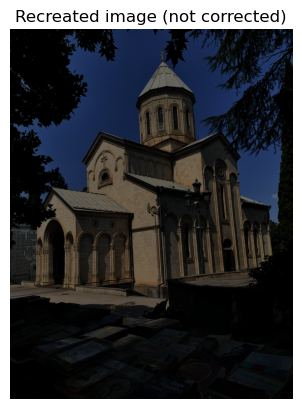

In [54]:
# This is how the image looks like if we don't correct albedo and shading

linear_recreated_img = albedo * shading
plt.title("Recreated image (not corrected)")
imshow(linear_recreated_img)

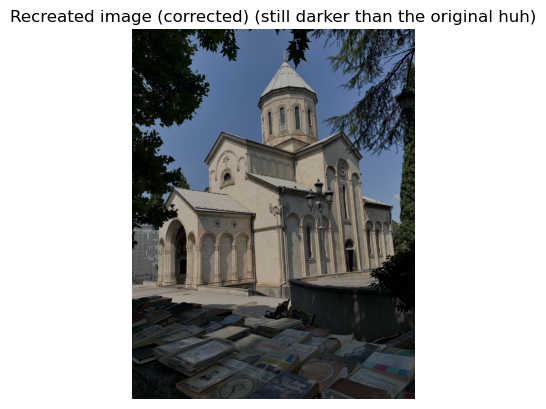

In [55]:
albedo_corrected = albedo ** 0.4545
shading_corrected = shading ** 0.4545
# recreated_img = albedo_corrected * shading_corrected\
recreated_img = linear_recreated_img ** 0.4545  # Apply gamma correction to final linear image, rather than the individual components (albedo, shading)

plt.title("Recreated image (corrected) (still darker than the original huh)")
imshow(recreated_img)

## Now actual relighting... Create new shading 
It's working! Kind of. The scene is way too dark but it relights the building perfectly

np.ndarray.max(normals)= 1.0, np.ndarray.min(normals)= 0.0
normals[300, 250, :]= array([0.5019608 , 0.50980395, 0.5176471 ], dtype=float32)


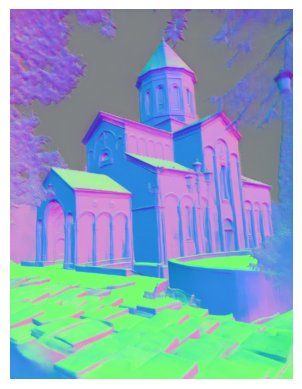

In [56]:
# So this is what our normals look like
imshow(normals)
print(f"{np.ndarray.max(normals)= }, {np.ndarray.min(normals)= }")
print(f"{normals[300, 250, :]= }")  # Point in the background / sky

In [57]:
# Normalize the normals
# Separate the RGB channels
red_channel = normals[:,:,0]
green_channel = normals[:,:,1]
blue_channel = normals[:,:,2]

# Normalize the values of the RGB channels
red_channel_normalized = red_channel / 255.0
green_channel_normalized = green_channel / 255.0
blue_channel_normalized = blue_channel / 255.0

# Create a new 2D array to hold the unit vectors
unit_vectors = np.zeros_like(normals)

# Iterate over each pixel and calculate the unit vector
for i in range(normals.shape[0]):
    for j in range(normals.shape[1]):
        x = red_channel_normalized[i,j]
        y = green_channel_normalized[i,j]
        z = blue_channel_normalized[i,j]
        magnitude = np.sqrt(x**2 + y**2 + z**2)
        if magnitude > 0:
            unit_vectors[i,j,0] = x / magnitude
            unit_vectors[i,j,1] = y / magnitude
            unit_vectors[i,j,2] = z / magnitude
# Make normals in a range from -1 to 1
print(f"{np.ndarray.max(normals)= }, {np.ndarray.min(normals)= }")
# normals = unit_vectors * 2 - 1

np.ndarray.max(normals)= 1.0, np.ndarray.min(normals)= 0.0


np.ndarray.max(normals)= 1.0, np.ndarray.min(normals)= 0.0
normals[300, 250, :]= array([0.5019608 , 0.50980395, 0.5176471 ], dtype=float32)


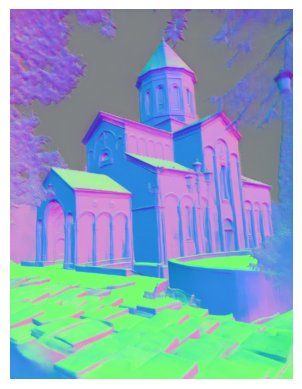

In [58]:
imshow(normals)
print(f"{np.ndarray.max(normals)= }, {np.ndarray.min(normals)= }")
print(f"{normals[300, 250, :]= }")  # Point in the background / sky

In order to get a new shabby relit image, call the calculate_shading function (below) with two inputs:
* light_dir = light direction in a form of a directional vector, doesn't need to be normalized
* a normals map

In [59]:
# Returns a normalized light vector with the same dimensions as the original image
def get_new_light_dir(light_dir, original_image):
    light_dir = np.array(light_dir)
    magnitude = np.sum(light_dir ** 2)
    normalized_light_dir = light_dir / magnitude
    
    new_light_dir = np.zeros(np.shape(original_image))
    new_light_dir[:] = normalized_light_dir
    
    return new_light_dir

In [60]:
def calculate_shading(light_dir, normals):
    new_light_dir = get_new_light_dir(light_dir, normals)
    
    # Dot product (np.dot doesn't work for more than 2 dimensions)
    new_shading = normals * new_light_dir
    new_shading = np.sum(new_shading, axis=2)
    # new_shading = new_shading * 0.5 + 1
    # new_shading = normals @ light_dir
    
    # Stack the single grayscale value in three RGB channels
    new_shading = np.dstack([new_shading, new_shading, new_shading])
    
    imshow(new_shading)
    
    # If we use the albedo_corrected in this equation (albedo ** 0.4545), the image looks a lot brighter
    # print(f"albedo range[{np.ndarray.min(albedo)}, {np.ndarray.max(albedo)}], new_shading range [{np.ndarray.min(new_shading)},{np.ndarray.max(new_shading)}]")
    new_image = albedo * new_shading
    # new_image = (new_image * 0.5) + 1
    
    # TODO: this gives us NaN values!
    # new_image = new_image ** 0.4545
    
    return new_image

In [ ]:
def showcase_new_shading():
    top_shading = calculate_shading([0, 1, 0], normals)
    right_shading = calculate_shading([-1, 0, 0], normals)
    left_shading = calculate_shading([1, 0, 0], normals)
    bottom_shading = calculate_shading([0, 0, 1], normals)
    slightly_left = calculate_shading([1, 1, 0], normals)
    top_plus_right_shading = (top_shading + right_shading)
    all_direction_shading = (top_shading + right_shading + left_shading + bottom_shading)
    
    fig, ax = plt.subplot_mosaic([['image', 'top', 'left', 'right', 'slightly_left', 'right_plus_top', 'all']], figsize=(20,4.5))

    ax['image'].imshow(img)
    ax['image'].axis('off')
    ax['image'].set_title('Original')

    ax['top'].imshow(top_shading)
    ax['top'].axis('off')
    ax['top'].set_title('Top shading')

    ax['left'].imshow(left_shading)
    ax['left'].axis('off')
    ax['left'].set_title('Left shading')

    ax['right'].imshow(right_shading)
    ax['right'].axis('off')
    ax['right'].set_title('Right shading')

    ax['slightly_left'].imshow(slightly_left)
    ax['slightly_left'].axis('off')
    ax['slightly_left'].set_title('Slightly left shading')

    ax['right_plus_top'].imshow(top_plus_right_shading)
    ax['right_plus_top'].axis('off')
    ax['right_plus_top'].set_title('Top + right shading')

    ax['all'].imshow(all_direction_shading)
    ax['all'].axis('off')
    ax['all'].set_title('Sum of all shading directions')

    plt.show()

In [62]:
def multiple_light_sum(light_dirs, ):
    pass

-> ## Work so far (visual showcase)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


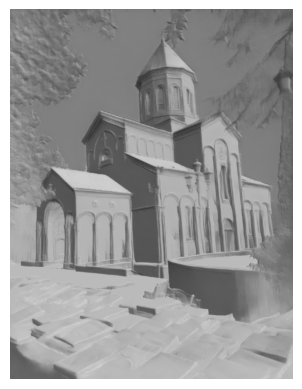

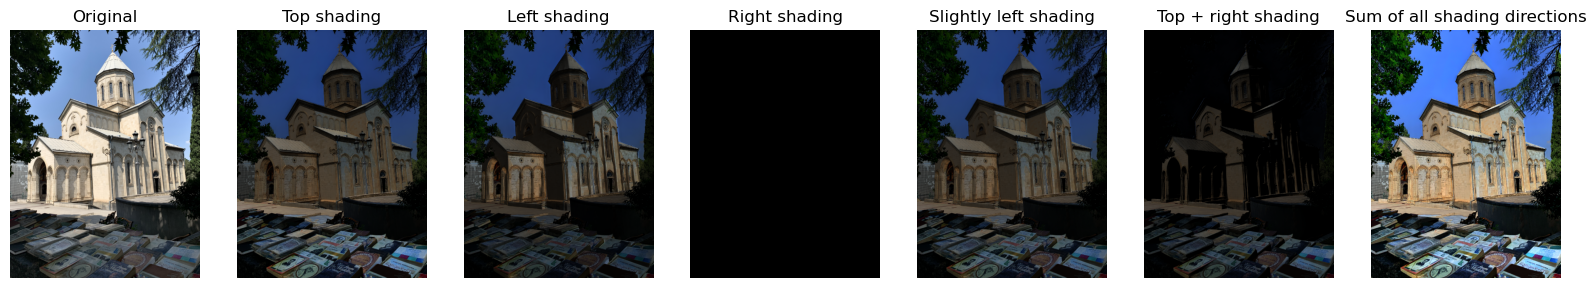

In [63]:
showcase_new_shading()

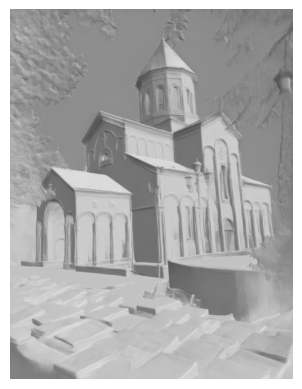

In [35]:
slightly_left = calculate_shading([1, 1, 0.3], normals)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


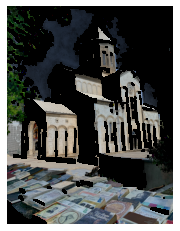

In [23]:
imshow(slightly_left)

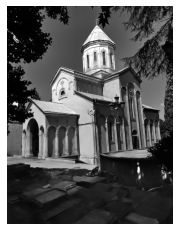

In [16]:
imshow(shading)

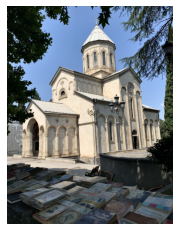

In [17]:
imshow(img)

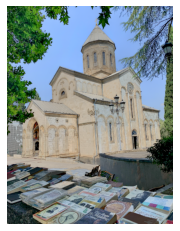

In [18]:
imshow(albedo_corrected)

### Here we will create a 3D mesh grid using the depth image, and apply ray casting to simulate light in 3D space
The parameter *depth_resolution* determines the number of discrete points sampled in the z direction.
The parameter *light_origin* is used to set the point of the light within the scene

In [6]:
depth_map = cv2.imread('./church/depth_bmd_ordinal.png', cv2.IMREAD_ANYDEPTH)
depth_resolution = 32
depth_map = np.array(depth_map / np.max(depth_map) * depth_resolution, dtype='uint8')
light_origin = np.array([250, 250, 8])
print(f"{depth_map.shape= }")
print(f"{np.min(depth_map)= }, {np.max(depth_map)= }")

depth_map.shape= (1216, 928)
np.min(depth_map)= 0, np.max(depth_map)= 32


In [7]:
x = np.arange(0, depth_map.shape[1])
y = np.arange(0, depth_map.shape[0])
z = np.arange(0, depth_resolution)
print(f"{x.shape= }, {y.shape= }, {z.shape= }")

# Create sparse meshgrids for use in computing euclidean distance from the light source
xx, yy, zz = np.meshgrid(x, y, z, sparse=True)
print(f"{xx.shape= }, {yy.shape= }, {zz.shape= }")

x.shape= (928,), y.shape= (1216,), z.shape= (32,)
xx.shape= (1, 928, 1), yy.shape= (1216, 1, 1), zz.shape= (1, 1, 32)


In [8]:
def distance_3d(x_point, y_point, z_point, xx, yy, zz):
    point1 = np.array([x_point, y_point, z_point])
    point2 = np.array([xx, yy, zz])
    return np.linalg.norm(point2 - point1)

distances = distance_3d(light_origin[0], light_origin[1], light_origin[2], xx, yy, zz)
print(f"{distances.shape= }")
print(f"{light_origin= }")
print(f"{distances[250, 250, 8]= }, {distances[250, 255, 8]= }")

/tmp/ipykernel_11883/3278405629.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  point2 = np.array([xx, yy, zz])


distances.shape= (1216, 928, 32)
light_origin= array([250, 250,   8])
distances[250, 250, 8]= 0.0, distances[250, 255, 8]= 5.0


In [9]:
def unit_direction_3d(x_point, y_point, z_point, xx, yy, zz):
    point1 = np.array([x_point, y_point, z_point])
    point2 = np.array([xx, yy, zz])
    magnitude = np.linalg.norm(point2 - point1)
    directions_meshgrids = (point2 - point1)
    direction_x = np.ones_like(magnitude) * directions_meshgrids[0]
    direction_y = np.ones_like(magnitude) * directions_meshgrids[1]
    direction_z = np.ones_like(magnitude) * directions_meshgrids[2]
    direction_vectors = np.stack((direction_x, direction_y, direction_z), axis=-1)
    print(f"{magnitude.shape= }")
    print(f"{direction_vectors.shape= }")
    return direction_vectors / magnitude[..., np.newaxis]

direction_vector_field = unit_direction_3d(light_origin[0], light_origin[1], light_origin[2], xx, yy, zz)
print(f"{direction_vector_field.shape= }, {direction_vector_field[250, 250, 8]= }, {direction_vector_field[250, 251, 8]= }, {direction_vector_field[250, 260, 8]= }")
print(f"{direction_vector_field[250, 250, 10]= }, {direction_vector_field[250, 250, 6]= }, {direction_vector_field[250, 400, 6]= }")

/tmp/ipykernel_11883/927825111.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  point2 = np.array([xx, yy, zz])


magnitude.shape= (1216, 928, 32)
direction_vectors.shape= (1216, 928, 32, 3)
direction_vector_field.shape= (1216, 928, 32, 3), direction_vector_field[250, 250, 8]= array([nan, nan, nan]), direction_vector_field[250, 251, 8]= array([1., 0., 0.]), direction_vector_field[250, 260, 8]= array([1., 0., 0.])
direction_vector_field[250, 250, 10]= array([0., 0., 1.]), direction_vector_field[250, 250, 6]= array([ 0.,  0., -1.]), direction_vector_field[250, 400, 6]= array([ 0.99991112,  0.        , -0.01333215])


/tmp/ipykernel_11883/927825111.py:12: RuntimeWarning: invalid value encountered in true_divide
  return direction_vectors / magnitude[..., np.newaxis]
